# Provable Robustness for Deep Classifiers

In this notebook, we will implement the robustness certificate that we derived in the PDF. That is, we will first define and train a three-layer neural classifier; then, we will calculate its dual, and using this, check whether the classifier is dual at given input points.

**Your task is to fill in any sections labeled TODO in the code and answer the bolded questions.**

## Torch

We are using torch here; for our purposes, we can think of torch as essentially numpy with GPU support and and automatic differentiation. That is, for any function we compute, torch automatically keeps track of the function's gradient with respect to inputs; this will make gradient descent much easier to implement. 

The primary object you will need to manipulate here is `torch.Tensor`, which can be thought of as equivalent to  `np.array`. Indexing, splicing, multiplication, etc. will work like you would expect them to in numpy.

Also, most of the numpy functions you are used to are present in torch, with the same name. E.g:
* `np.max(input, axis)` --> `torch.max(input, dim)` (Note that `torch.max` actually returns a tuple of the max and argmax).
* `np.zeros` --> `torch.zeros`
* `np.eye` --> `torch.eye`
* `np.linalg.norm(x, ord, axis)` --> `torch.norm(input, p, dim)`

For more information, refer to the [torch documentation](https://pytorch.org/docs/stable/torch.html) or the [torch tutorials](https://pytorch.org/tutorials/).

## Setup

Here, we import the relevant libraries.

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image, ImageOps

This line tells torch to use the GPU if available, and otherwise the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Here, we load in the MNIST dataset. The inputs are $28\times 28$ images of handwritten digits, while the labels are the corresponding digit. Note that we split the data between a training set and a test set. In order to have an unbiased estimate of the classifier's performance, we must train the model only on the training set (**never the test set**), then test its accuracy on the test set.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
transform = transforms.Compose([transforms.CenterCrop((28, 28)),
                                transforms.Grayscale(1),
                                transforms.ToTensor()])
mixed_images = datasets.ImageFolder('/Users/calamos/Desktop/pixmix/ImageFolder', transform=transform)

In [5]:
def get_random_mixer():
    return torch.utils.data.Subset(mixed_images, [np.random.randint(18930)])[0][0].squeeze(0)

def get_random_mnist():
    return torch.utils.data.Subset(trainset, [np.random.randint(60000)])[0][0].squeeze(0)

In [7]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

In [8]:
IMAGE_SIZE = 28

In [9]:
### Credit: Hendrycks, Zou, et al. (2022)
### AUGMENTATIONS ###
def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    ###NOTE: removed from list of augmentations since some digits are not rotation-invariant
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)

augmentations = [
    autocontrast, equalize, posterize, shear_x, shear_y,
    translate_x, translate_y
]

In [10]:
### Credit: Hendrycks, Zou, et al. (2022)
### MIXINGS ###
def get_ab(beta):
  if np.random.random() < 0.5:
    a = np.float32(np.random.beta(beta, 1))
    b = np.float32(np.random.beta(1, beta))
  else:
    a = 1 + np.float32(np.random.beta(1, beta))
    b = -np.float32(np.random.beta(1, beta))
  return a, b

def add(img1, img2, beta):
  a,b = get_ab(beta)
  img1, img2 = img1 * 2 - 1, img2 * 2 - 1
  out = a * img1 + b * img2
  return (out + 1) / 2

def multiply(img1, img2, beta):
    a, b = get_ab(beta)
    img1, img2 = img1 * 2, img2 * 2
    img1 = torch.clip(img1, 0, 1)
    img2 = torch.clip(img2, 0, 1)
    out = (img1 ** a) * (img2.clip(1e-37) ** b)
    return out / 2

mixings = [add, multiply]


In [11]:
pil_transform = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

def pixmix(orig, k=4, beta=3, level=30):
    ### Code based of off Hendrycks, Zou, et al. (2022)
    
    augment_input = np.random.choice(augmentations) 
    
    #50/50 chance of getting augmented  
    if np.random.random() < 0.5: 
        orig = to_tensor(augment_input(pil_transform(orig), level))
  
    for _ in range(1, np.random.randint(2, k+1)):
        #50/50 chance of getting augmented
        if np.random.random() < 0.5:
            augment_input = np.random.choice(augmentations)
            aug_image_copy = to_tensor(augment_input(pil_transform(orig), level))
           
        else:
            aug_image_copy = get_random_mixer()
            
        mixed_op = np.random.choice(mixings)          #50/50 chance either multiplicative or additive mixing
        orig = mixed_op(orig, aug_image_copy, beta) #mixed according to beta distribution
        orig = torch.clip(orig, 0, 1)               #making sure all values are either 0 or 1

    return orig

## Primal Network

Here, we define the neural classifier we will be using. Note that the network comprises three layers. The first layer has dimension $28^2$ since this is the size of the input image. (The original inputs are square images, but we flatten them into a $28^2\times 1$ vector in order to feed them into the network.) The output layer has dimension $10$, since there are ten possible output classes (the digits 0-9). The hidden layer has dimension $256$. (There isn't as much science behind choosing the dimensionality of input layers; we choose $256$ because it is a round number, and is hopefully enough to the neccesary encode information about the input image.)

In [20]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(in_features=28*28, out_features = 256)
    self.fc2 = nn.Linear(in_features=256, out_features = 10)
    self.layers = [self.fc1, self.fc2]

  # define forward function
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    t = t.reshape(-1, 28*28)
    t = self.fc1(t)
    self.z.append(t)
    t = F.relu(t)
    t = self.fc2(t)
    self.z.append(t)
    return t

Here is the training code, which uses Adam, a variant of gradient descent. The actual optimization machinery is all abstracted away behind the torch library; all the work is being done by the `optimizer.step()` call.

In [21]:
def train(net, criterion, trainloader, lr=0.001, pixmix_include=False):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)
            
            if pixmix_include:
                for j in range(4):
                    data[0][j] = pixmix(data[0][j].squeeze(0))
       
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

In [98]:
pixmix_net = Net()
pixmix_net.to(device)

criterion = nn.CrossEntropyLoss()

train(pixmix_net, criterion, trainloader, 0.001, pixmix_include=True)

Epoch 0 Iter: 0 Loss 2.292419195175171
Epoch 0 Iter: 500 Loss 1.4503562450408936
Epoch 0 Iter: 1000 Loss 1.3641966581344604
Epoch 0 Iter: 1500 Loss 0.12120817601680756
Epoch 0 Iter: 2000 Loss 0.8255091905593872
Epoch 0 Iter: 2500 Loss 1.358978033065796
Epoch 0 Iter: 3000 Loss 0.30382421612739563
Epoch 0 Iter: 3500 Loss 1.834344744682312
Epoch 0 Iter: 4000 Loss 0.9534880518913269
Epoch 0 Iter: 4500 Loss 1.309092402458191
Epoch 0 Iter: 5000 Loss 1.4110782146453857
Epoch 0 Iter: 5500 Loss 0.5855514407157898
Epoch 0 Iter: 6000 Loss 0.5719462037086487
Epoch 0 Iter: 6500 Loss 2.4939351081848145
Epoch 0 Iter: 7000 Loss 0.9179906249046326
Epoch 0 Iter: 7500 Loss 1.1456196308135986
Epoch 0 Iter: 8000 Loss 2.965188503265381
Epoch 0 Iter: 8500 Loss 1.5813380479812622
Epoch 0 Iter: 9000 Loss 1.0177552700042725
Epoch 0 Iter: 9500 Loss 0.5175808072090149
Epoch 0 Iter: 10000 Loss 0.11697157472372055
Epoch 0 Iter: 10500 Loss 1.2233027219772339
Epoch 0 Iter: 11000 Loss 1.2238913774490356
Epoch 0 Iter: 

We can now train the net on the training data, using cross entropy loss.

In [23]:
net = Net()
net.to(device)
train(net, criterion, trainloader, 0.001)

Epoch 0 Iter: 0 Loss 2.076387643814087
Epoch 0 Iter: 500 Loss 0.09691828489303589
Epoch 0 Iter: 1000 Loss 0.3168752193450928
Epoch 0 Iter: 1500 Loss 0.3807903528213501
Epoch 0 Iter: 2000 Loss 0.5989309549331665
Epoch 0 Iter: 2500 Loss 0.16271135210990906
Epoch 0 Iter: 3000 Loss 0.11950799822807312
Epoch 0 Iter: 3500 Loss 0.40232014656066895
Epoch 0 Iter: 4000 Loss 0.3367736339569092
Epoch 0 Iter: 4500 Loss 0.06069811061024666
Epoch 0 Iter: 5000 Loss 0.06280850619077682
Epoch 0 Iter: 5500 Loss 0.07447119057178497
Epoch 0 Iter: 6000 Loss 1.1219135522842407
Epoch 0 Iter: 6500 Loss 0.005711544305086136
Epoch 0 Iter: 7000 Loss 0.06395470350980759
Epoch 0 Iter: 7500 Loss 1.4254060983657837
Epoch 0 Iter: 8000 Loss 0.47384870052337646
Epoch 0 Iter: 8500 Loss 0.0019471724517643452
Epoch 0 Iter: 9000 Loss 0.04099069908261299
Epoch 0 Iter: 9500 Loss 0.05247088521718979
Epoch 0 Iter: 10000 Loss 1.5421555042266846
Epoch 0 Iter: 10500 Loss 0.05581703782081604
Epoch 0 Iter: 11000 Loss 0.0094689531251

Let's load a sample image from the test dataset, and see what the classifier makes of it. Make sure to visualize the image using `imshow(x[0,0])`. Also, note that the line `test_iter.next()` pulls a new input image from the test set each time you run it; try running the next code block a few times to get a sense of what the MNIST dataset looks like, and how the classifier performs on it.

In [29]:
test_iter = iter(testloader)

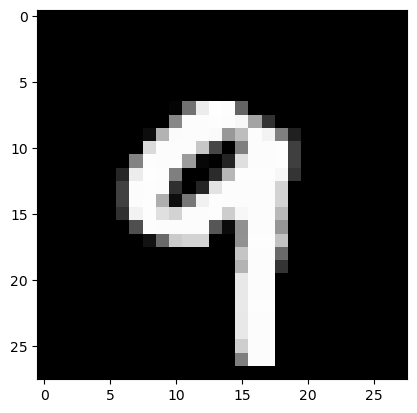

Classifier output: tensor([[-15.9762, -18.4431,  -8.5127,  -5.2935,   1.6888,  -6.8093, -17.0520,
          -3.5776,  -5.3791,   8.5815]])
Classifier prediction: 9


In [182]:
x, labels = test_iter.next()
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

We can also measure the classifier's accuracy on the full test dataset. This function takes in a classifier we have trained and the loader for the test set, and outputs the classifier's accuracy. The accuracy is simply
$$ \dfrac{\text{# correct}}{\text{# total}}.$$

In [32]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [33]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.9682


## Fast Gradient Sign Method

Here, we implement the Fast Gradient Sign Method, which takes in a batch of input images, their labels, a trained classifier, and the epsilon radius within which the perturbation should lie. This function should output the input image perturbed in the direction of the sign of the gradient with respect to the classifier's loss.

(Note that the output is not guaranteed to lie in the valid range for images, since here pixel values must be in $[-1,1]$. You should use `torch.clamp` to fix the FGSM output to lie in the correct range.)

In [34]:
def FGSM(x, labels, net, eps):
    '''
    Given an input image X and its corresponding labels
    LABELS, as well as a classifier NET, returns X
    perturbed by EPS using the fast gradient sign method.
    '''
    net.zero_grad()    # Zero out any gradients from before
    x.requires_grad=True    # Keep track of gradients
    out = net(x)    # Output of classifier
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, labels)   # Classifier's loss
    loss.backward()
    grads = x.grad.data    # Gradient of loss w/r/t input
    
    #print(torch.clamp(out, -1, 1).size())
    #print(torch.mul(torch.sign(grads), eps).size())
    
    return torch.clamp(x + torch.sign(grads) * eps, -1, 1)# TODO: Your code here!

Let's see how well the classifier does when the input is adversarially perturbed using FGSM. Try this for $\varepsilon\in\{0.05, 0.1,0.2,0.3, 0.4\}$, and again remember to visualize the inputs with `imshow`.

In [35]:
eps = 0.05 # TODO: Try eps = 0.05, 0.1, 0.2, 0.3, 0.4

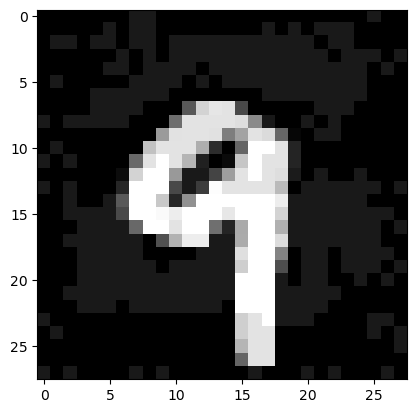

Classifier output: tensor([[-14.0217, -15.2018,  -4.7494,  -6.4919,   5.4696,  -5.5263,  -8.1230,
          -6.0675,  -5.7762,   2.6270]])
Classifier prediction: 4


In [183]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

We should evaluate the classifier's performance on FGSM-perturbed data by the same metric that we will later use in the primal adversarial problem. That is, for the classifier's output vector $\vec{\hat{z}}_3$, we want to compute
$$
\vec{c}_j^\top \vec{\hat{z}}_3
$$
where
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

Recall that 
$$\vec{c}_j^\top \vec{\hat{z}}_3=\vec{\hat{z}}_{3i_{\text{true}}}-\vec{\hat{z}}_{3j},$$
i.e. $\vec{c}_j^\top \vec{\hat{z}}_3$ is the difference between the classifier's confidence on the true class and the $j$th (incorrect) class. If $\vec{c}_j^\top \vec{\hat{z}}_3$ is positive for all incorrect $j$, then the classifier was not fooled by the adversarial perturbation.

In [204]:
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, (out @ c).item())

0 19.491268157958984
1 20.67140769958496
2 10.219018936157227
3 11.961532592773438
5 10.995853424072266
6 13.592636108398438
7 11.537052154541016
8 11.245810508728027
9 2.8426127433776855


**Q: What do the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores tell you about the robustness of the classifier to different values of epsilon? For a given input digit, which output categories have higher/lower scores? Why?**

<span style="color:blue">A: The scores are all positive at an epsilon value of 0.05, which tells me that the robustness of the classifier is good as the classifier was not fooled by the adversarial perturbation. As epsilon increased, the classifier was more and more fooled by adversarial perturbation as more scores became negative and the classifier visually misidentified numbers.</span>
    
<span style="color:blue"> In general, digits more similar to the true label (e.g. 9 if the label is 4) will have lower scores, since it is easier to "fool" the classifier into thinking one is the other. Conversely, less similar digits will tend to have higher scores (e.g. 1 if the label is 4).</span>

Now that FGSM is defined, we can also measure a classifier's accuracy on a dataset where each input has been adversarially perturbed. That is, for each point in the original test dataset, we first perturb it using FGSM before feeding it to the classifier.

In [40]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [202]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.9234


**Q: How does the classifier accuracy on data perturbed by FGSM compare to that on the original test dataset? How does this vary with epsilon?**

<span style="color:blue"> A: With an epsilon of 0.05, the FGSM perturbed data gets a slightly lower accuracy (roughly 0.97 vs 0.92). When an epsilon of 0.5, the accuracy plummets down to around zero. Therefore, a higher epsilon decreases the accuracy.</span>

## Dual Network

Here, we will implement the dual network. First, we write the function to compute upper and lower bounds for the dual network. This function should take an input image, the trained classifier, and an epsilon value, and return the tuple
$$(\vec{l},\vec{u},S,S^-,S^+)$$
where $\vec{u}$ and $\vec{l}$ are the upper and lower bounds, respectively, for the input to the ReLU layer, and $S^-,S^+,S$ are sets defined by

$$
\begin{aligned}
&S:=\{j\in [n_2]\mid l_{j}\leq 0\leq u_{j}\}\\
&S^{-}:=\{j\in [n_2]\mid l_{j}\leq u_{j}\leq 0\}\\
&S^{+}:=\{j\in [n_2]\mid 0\leq l_{j}\leq u_{j}\}.
\end{aligned}
$$

See Section 6 of the PDF for more details.

In [122]:
def dual_bounds(x, net, eps):
    '''
    Given a classifier NET, an input image X,
    and the epsilon parameter EPS, returns the lower
    and upper bounds L and U respectively, as well as
    the corresponding sets S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    
    
    u = torch.matmul(W[0], x) + b[0] + torch.matmul(W[0], torch.mul(torch.ones(W[0].shape[1]),eps)).reshape(-1,1)# TODO
    l = torch.matmul(W[0], x) + b[0] - torch.matmul(W[0], torch.mul(torch.ones(W[0].shape[1]),eps)).reshape(-1,1)# TODO
    
    S = [] #TODO
    S_plus = [] # TODO
    S_min = [] # TODO
    
    i = 0
    for u_j, l_j in zip(list(u), list(l)):
        if u_j <= 0:
            S_min.append(i)
        if l_j >=0 :
            S_plus.append(i)
        if (u_j >= 0) and (l_j <=0):
            S.append(i)
        i += 1
    
    return l, u, S, S_min, S_plus

Given the tuple $(l,u,S,S^-,S^+)$, we are ready to calculate the dual objective itself. This function should take in an input image, the classifier, a vector $c$, and the $(l,u,S,S^-,S^+)$ from the previous function in order to output 
$$
d^*(\vec{x},\vec{c})= 
-\vec{\hat{\nu}}_1^\top \vec{x}-\varepsilon\|\vec{\hat{\nu}}_1\|_1-\sum_{i=1}^{2}\vec{\nu}_{i+1}^\top \vec{b}_i+\sum_{j\in S\
}l_{j}\text{ReLU}(\nu_{2j})
$$

Where the $\vec{\nu}$ vectors are computed as
$$
\begin{aligned}
&\vec{\nu}_3=-\vec{c}\\
&\vec{\hat{\nu}}_2=W_2^\top \vec{\nu}_{3}\\
&\nu_{2j}=0 && \forall j\in S^-\\
&\nu_{2j}=\hat{\nu}_{2j} && \forall j\in S^+\\
&\nu_{2j}=\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} && \forall j\in S\\
&\vec{\hat{\nu}}_1=W_1^\top \vec{\nu_{2}}
&\end{aligned}.
$$

Again, see Section 6 of the PDF for more details.

One efficient way to compute $\vec{\nu}_2$ is to rewrite it as
$$\vec{\nu}_2= D\vec{\hat{\nu}}_2,$$
where $D$ is a diagonal matrix defined  by
$$
D_{jj}=\begin{cases}
0 & j\in S^-\\
\hat{\nu}_{2j} & j\in S^+\\
\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} & j\in S.
\end{cases}
$$

In [123]:
# Constructs the diagonal D matrix from the S sets, n (the dimensionality
# of the hidden layer), u, and l.
def StoD(S_min, S_plus, S, n, u, l):
    '''
    Given upper and lower bounds U and L, as well
    as the corresponding sets S_MIN, S_PLUS, and S,
    as well as the dimension of the hidden layer N,
    returns the corresponding diagonal matrix D.
    '''
    d = []
    for j in range(n):
        if j in S:
            d.append((u[j] / (u[j] - l[j])).item())
        elif j in S_plus:
            d.append(1)
        elif j in S_min:
            d.append(0)
        else:
            assert False, 'StoD error.'
    return torch.diag(torch.Tensor(d)).to(device)

def dual_forward(x, net, c, eps, l, u, S, S_min, S_plus):
    '''
    Calculates the dual objective for classifier NET with input X
    and dual input C and epsilon parameter S. Depends on lower
    and upper bounds L and U, as well as the corresponding sets
    S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    D = StoD(S_min, S_plus, S, n, u, l)
    # TODO: Your code here!
    
    
    
    v3 = -c
    v2_hat = W[1].T @ v3 # W2 
    
    temp_ReLU = nn.ReLU()
    v2 = D @ v2_hat
    #v2 = temp_ReLU(v2_hat)
    
    v1_hat = W[0].T @ v2 # W1 
    
    first_term = - v1_hat.T @ x 
    second_term = - eps * torch.linalg.vector_norm(v1_hat, ord=1)
    
    result = first_term + second_term
    
    #third term
    #result -= v2.T @ b[0] + v3.T @ b[1]
    
    
    for pair in [[v2, b[0]], [v3, b[1]]]: # what is v????
        temp_v = pair[0]
        temp_b = pair[1]
        temp_term = temp_v.T @ temp_b
        result -= temp_term
    
    #fourth term

    # sum up S
    #temp =  l * temp_ReLU(torch.div(u, u-l)).reshape(-1, 1)
    
    for j in S:
        v2_hat_j = v2_hat[j]
        S_v2_j = (u[j]/(u[j]-l[j])) * v2_hat_j
        temp_sum = l[j] * temp_ReLU(S_v2_j).reshape(-1, 1)
        result += temp_sum
    
    return result # TODO

Now, we can use the dual network to check the robustness of the network we just trained on sample input images. We can do this for 
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

The output is a vector where the $j$th element is the difference between the model's confidence in the true class and the $j$th class; if $d^*(\vec{x},\vec{c}_j)$ is nonnegative for every $j\in[10]$, then we know the model is robust to perturbations of size $\varepsilon$. See Section 8 of the PDF for more details.

Try running the following block of code for different values of $\varepsilon\in\{0.05, 0.1, 0.2, 0.3, 0.4\}$, and compare the robustness guarantees here with the classifier's performance on the FGSM data from before.

torch.Size([28, 28])


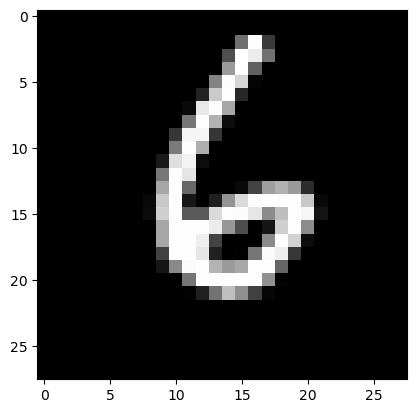

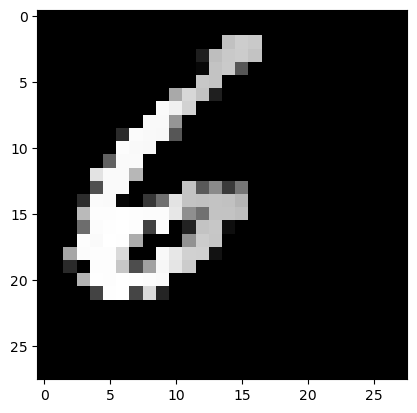

In [232]:
print("Sample PixMix Alterations")
x, labels = test_iter.next()
x = x[0].unsqueeze(0)
imshow(x[0,0])
pix = pixmix(x.squeeze(0).squeeze(0))
imshow(pix.squeeze(0))


In [199]:
eps = 0.05

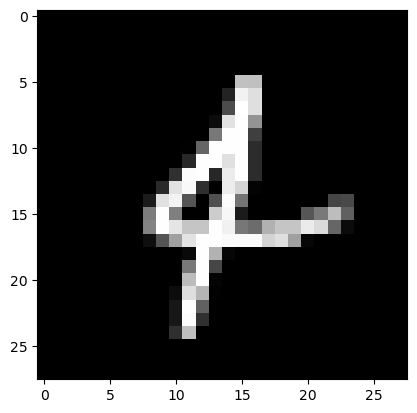

In [200]:
x, labels = test_iter.next()
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])
x_prime = FGSM(x, labels, net, eps)
x = x.to(device)
labels = labels.to(device)

In [201]:
#x, labels = next(test_iter)
# We are still using the same sample input x as before.
#l, u, S, S_min, S_plus = dual_bounds(x, net, eps)

# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
print(labels)
for i in range(10):
    c = torch.zeros(10, 1).to(device)
   
    if True:#!= labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).item())
        #print()
        print(i, dual_forward(x_prime, net, c, eps, l, u, S, S_min, S_plus).item())

tensor([4])
0 17.080739974975586
0 16.01530647277832
1 16.495615005493164
1 14.004545211791992
2 20.77235221862793
2 17.792997360229492
3 17.686988830566406
3 15.348034858703613
4 17.122060775756836
4 14.901432991027832
5 12.30077838897705
5 10.349495887756348
6 3.3176918029785156
6 1.5781501531600952
7 19.43744659423828
7 17.609344482421875
8 10.686287879943848
8 9.028590202331543
9 15.862046241760254
9 15.466729164123535


**Q: What do the dual network outputs tell you about the robustness of the classifier? How does this compare to the classifier's performance (in particular, the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores) on FGSM outputs? How does your answer change with epsilon?**


<span style="color:blue"> A: If the outputs are positive value for all $j \neq i_{true}$, then the classifier is robust to adversarial attacks with epsilon bounds. The classifier performs "worse" in adversarially-optimized examples since its outsputs are lower than its outputs without the perturbation (i.e. it is less confident in its answer) but the values are still positive, to it is correctly classifying outputs (at least for the example above). The performace of the network decreases as $\varepsilon$ increases.</span>

**Q: Suppose you have a deep neural classifier that you want to defend against adversarial attacks. That is, you want to detect and discard any input images that were possibly adversarially perturbed. How might you do this with the robustness certificate you have implemented?**

<span style="color:blue"> A: With the robutstness certificate we can say confidently that there can be no perturbation within the epsilon bound on the $\|\vec{x}-\vec{x}'\|_{\infty}$ such that the classifier is incorrect on the perturbed data. In essence, we would then want to discard all input images that have a negative $\vec{c}_j^\top \vec{\hat{z}}_3$ value for any $j \neq i_{true}$. </span>

## Robust training

The following function should implement the robust loss from section A of the PDF. This loss is an upper bound on the worst-case loss within an $\epsilon$ ball of the original training input. Thus, training using this new loss should result in a classifier that is more robust than one trained on the original cross-entropy loss.

There are no mandatory questions here, but feel free to experiment with this robust training, and compare the performance here (measured by the dual objective certificate, as well as original/FGSM accuracy) to that of the original. You can also try training a model using the original loss first, then fine-tuning with the robust loss.

In [133]:
def robust_loss(x, label, net, eps, criterion):
    '''
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    '''
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).unsqueeze(0)
    return criterion(-J, label.unsqueeze(0))

In [134]:
def robust_train(net, criterion, trainloader, eps, lr=0.001):
    '''
    Trains the classifier NET using the robust version
    of the original loss function CRITERION with paramater EPS,
    using training data from TRAINLOADER and with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for j, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data
            optimizer.zero_grad()
            loss = 0
            for i in range(inputs.shape[0]):
                x = inputs[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)
                loss += robust_loss(x, label, net, eps, criterion)
            loss.backward()
            optimizer.step()
    
            if j % 500 == 0:
                print('Epoch', epoch, 'Iter:', j, 'Loss', loss.item())

In [135]:
robust_net = Net()
robust_net.to(device)

criterion = nn.CrossEntropyLoss()
robust_train(robust_net, criterion, trainloader, 0.1, 0.001)

Epoch 0 Iter: 0 Loss 9.092131614685059
Epoch 0 Iter: 500 Loss 1.73777437210083
Epoch 0 Iter: 1000 Loss 0.6386905312538147
Epoch 0 Iter: 1500 Loss 0.06095507740974426
Epoch 0 Iter: 2000 Loss 2.0795907974243164
Epoch 0 Iter: 2500 Loss 0.4304622411727905
Epoch 0 Iter: 3000 Loss 0.5023509860038757
Epoch 0 Iter: 3500 Loss 1.2398611307144165
Epoch 0 Iter: 4000 Loss 2.4881815910339355
Epoch 0 Iter: 4500 Loss 0.01574050262570381
Epoch 0 Iter: 5000 Loss 0.16504336893558502
Epoch 0 Iter: 5500 Loss 1.3438102006912231
Epoch 0 Iter: 6000 Loss 0.20641100406646729
Epoch 0 Iter: 6500 Loss 0.12106574326753616
Epoch 0 Iter: 7000 Loss 6.198548316955566
Epoch 0 Iter: 7500 Loss 1.0179328918457031
Epoch 0 Iter: 8000 Loss 0.04461207985877991
Epoch 0 Iter: 8500 Loss 0.015454759821295738
Epoch 0 Iter: 9000 Loss 0.04472357779741287
Epoch 0 Iter: 9500 Loss 1.054599404335022
Epoch 0 Iter: 10000 Loss 0.5454970598220825
Epoch 0 Iter: 10500 Loss 1.526585340499878
Epoch 0 Iter: 11000 Loss 0.4376038908958435
Epoch 0 I

In [136]:
#acc_fgsm = {}
#pixmix_acc_fgsm = {}
#dual_acc_fgsm = {}
for eps in np.arange(0, 0.61, 0.025):
    #acc_fgsm[eps] =  accuracy_on_FGSM(net, testloader, eps)
    #pixmix_acc_fgsm[eps] =  accuracy_on_FGSM(pixmix_net, testloader, eps)
    dual_acc_fgsm[eps] =  accuracy_on_FGSM(robust_net, testloader, eps)

## Performance Comparison

Beyond $\epsilon \gtrapprox 0.22$, the network trained using PixMix outperforms the other networks. 

Interestingly, the pixmix-trained model seems to have a nonlinearity at $\epsilon \approx 0.08$, after which performace declines much slower. 

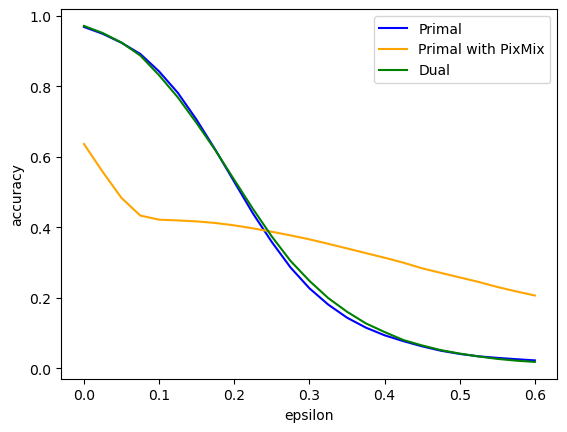

In [233]:
plt.plot(acc_fgsm.keys(), acc_fgsm.values(), color="blue", label="Primal")
plt.plot(pixmix_acc_fgsm.keys(), pixmix_acc_fgsm.values(), color="orange", label="Primal with PixMix")
plt.plot(dual_acc_fgsm.keys(), dual_acc_fgsm.values(), color="green", label="Dual")
plt.legend(loc="upper right")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.show()